In [22]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
import os
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor

In [15]:
class BlurSharpPairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.blur_dir = os.path.join(self.root_dir, 'blur')
        self.sharp_dir = os.path.join(self.root_dir, 'sharp')
        self.image_names = os.listdir(self.blur_dir)  # Assumes each blurred image has a corresponding sharp image

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        blur_image_path = os.path.join(self.blur_dir, self.image_names[idx])
        sharp_image_path = os.path.join(self.sharp_dir, self.image_names[idx])
        
        blur_image = Image.open(blur_image_path).convert("RGB")
        sharp_image = Image.open(sharp_image_path).convert("RGB")
        
        if self.transform:
            blur_image = self.transform(blur_image)
            sharp_image = self.transform(sharp_image)
        
        return blur_image, sharp_image

# Example usage
transform = Compose([
    Resize((256, 448)),
    ToTensor(),
])

test_data = BlurSharpPairDataset(root_dir='data/test', transform=transform)

test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [16]:
class Encoder(nn.Module):
    
    def __init__(self, input_shape = (3, 256, 448),encoded_space_dim = 256):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(128 * 31 * 55, 512),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(512, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [18]:
class Decoder(nn.Module):
    
    def __init__(self, input_shape = (3, 256, 448), encoded_space_dim = 256):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 512),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(512, 128 * 31 * 55),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128, 31, 55))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=0, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [23]:
encoder = Encoder().to('cuda')
decoder = Decoder().to('cuda')

encoder.load_state_dict(torch.load('models/encoder_30.pt'))
decoder.load_state_dict(torch.load('models/decoder_30.pt'))

encoder.eval()
decoder.eval()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=218240, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 31, 55))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  )
)

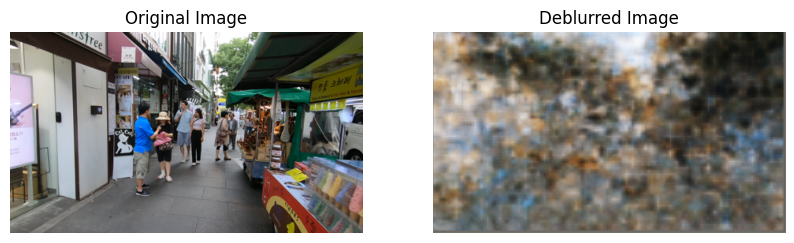

25.372631425044464


In [32]:
# Function to convert a tensor to a PIL image
def tensor_to_PIL(tensor):
    tensor = tensor.squeeze(0)  # Remove the batch dimension
    tensor = tensor.detach().cpu()
    tensor = torch.clamp(tensor, 0, 1)
    np_image = tensor.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))  # Convert from PyTorch to PIL image format
    return Image.fromarray((np_image * 255).astype('uint8'))

blur_image_path = 'data/test/blur/00200000043.png'
sharp_image_path = 'data/test/sharp/00200000043.png'

blur_image = transform(Image.open(blur_image_path).convert("RGB")).unsqueeze(0).to('cuda')  # Add batch dimension
sharp_image = transform(Image.open(sharp_image_path).convert("RGB")).unsqueeze(0).to('cuda')  # Add batch dimension

# Load a sample blurred image and its corresponding sharp image
# Replace 'path/to/image' with the actual path to your image
with torch.no_grad():  # No need to track gradients
    encoded_features = encoder(blur_image)
    deblurred_image = decoder(encoded_features)

# Convert the tensors to PIL images for visualization
deblurred_image_PIL = tensor_to_PIL(deblurred_image)
sharp_image_PIL = tensor_to_PIL(sharp_image)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sharp_image_PIL)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(deblurred_image_PIL)
axs[1].set_title('Deblurred Image')
axs[1].axis('off')

plt.show()

from skimage.metrics import peak_signal_noise_ratio
img1 = np.array(sharp_image_PIL)
img2 = np.array(deblurred_image_PIL)
img3 = np.array(tensor_to_PIL(blur_image))

print(peak_signal_noise_ratio(img1, img3))